In [5]:
import akshare as ak
import pandas as pd
stock_code = "000009"  
start_date = "20100101"  
end_date = "20210101"  
stock_hist_data = ak.stock_zh_a_hist(symbol=stock_code, adjust="hfq", start_date=start_date, end_date=end_date)
print(stock_hist_data.head())
stock_hist_data.to_csv('gupiao-data111.csv', index=False)

import pandas as pd
# Read stock data
stock_data = pd.read_csv('gupiao-data111.csv')
# Calculate the number of divided rows
train_rows = int(len(stock_data) * 0.8)
# Divide training set and test set
train_data = stock_data[:train_rows]
val_data = stock_data[train_rows:]
# Save as CSV file
train_data.to_csv('train111.csv', index=False)
val_data.to_csv('val111.csv', index=False)

E:\anaconda\envs\py39\lib\site-packages\akshare\__init__.py:2595: UserWarning: 为了支持更多特性，请将 Pandas 升级到 2.1.0 及以上版本！
  warnings.warn(


           日期     开盘     收盘     最高     最低     成交量          成交额    振幅   涨跌幅  \
0  2010-01-04  46.35  45.66  46.48  45.49  173627  189401392.0  2.14 -1.32   
1  2010-01-05  45.88  44.46  46.14  44.03  314633  332003936.0  4.62 -2.63   
2  2010-01-06  44.46  44.42  45.28  43.64  234084  246690064.0  3.69 -0.09   
3  2010-01-07  43.95  45.28  46.74  43.26  472863  506484096.0  7.83  1.94   
4  2010-01-08  45.06  47.51  47.73  44.42  553769  610549120.0  7.31  4.92   

    涨跌额   换手率  
0 -0.61  1.76  
1 -1.20  3.18  
2 -0.04  2.37  
3  0.86  4.79  
4  2.23  5.60  


E:\anaconda\envs\py39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
E:\anaconda\envs\py39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


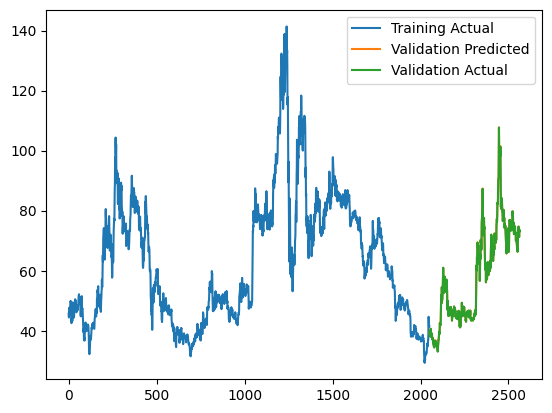

Running time: 13.133732080459595 seconds
Memory usage: 0.0 MB
MSE:  0.0029271052344700317
MAE:  0.03686633956624013
Final portfolio value:  1166828.3499999996
Total return:  666828.3499999996
Return rate:  133.36566999999994
Accuracy: 0.7914230019493177


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Read the stock price data of the training set and validation set
train_data = pd.read_csv('train111.csv')
val_data = pd.read_csv('val111.csv')

# Extract the Close column data of the training set and validation set
train_features = train_data['收盘'].values.reshape(-1, 1)
train_target = train_data['收盘'].values.reshape(-1)
val_features = val_data['收盘'].values.reshape(-1, 1)
val_target = val_data['收盘'].values.reshape(-1)

# Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
train_features = scaler.fit_transform(train_features)
train_target = scaler.fit_transform(train_target.reshape(-1, 1))
val_features = scaler.transform(val_features)
val_target = scaler.transform(val_target.reshape(-1, 1))



# Custom data set class
class StockDataset(Dataset):
     def __init__(self, features, target):
         self.features = torch.Tensor(features)
         self.target = torch.Tensor(target)
        
     def __len__(self):
         return len(self.features)
    
     def __getitem__(self, idx):
         return self.features[idx], self.target[idx]
    
# Instantiate the data set classes for the training set and validation set
train_dataset = StockDataset(train_features, train_target)
val_dataset = StockDataset(val_features, val_target)

# Instantiate data loader
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Build LSTM model
class LSTMModel(nn.Module):
     def __init__(self, input_size, hidden_size, output_size):
         super(LSTMModel, self).__init__()
         self.hidden_size = hidden_size
         self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
         self.fc = nn.Linear(hidden_size, output_size)
        
     def forward(self, x):
         _, (hidden, _) = self.lstm(x)
         output = self.fc(hidden[-1])
         return output
    
#Set model hyperparameters
input_size = 1
hidden_size = 50
output_size = 1
num_epochs = 10
learning_rate = 0.001

# Instantiate LSTM model
model = LSTMModel(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Record start time
start_time = time.time()

# Model training
for epoch in range(num_epochs):
     for features, target in train_loader:
         optimizer.zero_grad()
         output = model(features.unsqueeze(1))
         loss = criterion(output, target.unsqueeze(1))
         loss.backward()
         optimizer.step()

# Save model
torch.save(model, 'model-2.pth')

# Model prediction
predicted_train = []
predicted_val = []
with torch.no_grad():
     model.eval()
     for features, _ in train_loader:
         output = model(features.unsqueeze(1))
         predicted_train.append(output.item())

     for features, _ in val_loader:
         output = model(features.unsqueeze(1))
         predicted_val.append(output.item())

# Inverse normalization
predicted_train = scaler.inverse_transform(np.array(predicted_train).reshape(-1, 1)).squeeze()
predicted_val = scaler.inverse_transform(np.array(predicted_val).reshape(-1, 1)).squeeze()
train_target = scaler.inverse_transform(train_target).squeeze()
val_target = scaler.inverse_transform(val_target).squeeze()

# Draw line charts of the true values and predicted values of the training set and validation set
plt.plot(train_target, label='Training Actual')
plt.plot(range(len(train_target), len(train_target) + len(predicted_val)), predicted_val, label='Validation Predicted')
plt.plot(range(len(train_target), len(train_target) + len(val_target)), val_target, label='Validation Actual')
plt.legend()
plt.show()

# Calculate running time
running_time = time.time() - start_time # Unit: seconds
print("Running time:", running_time, "seconds")

# Calculate memory usage
memory_allocated = torch.cuda.memory_allocated() / 1024 / 1024 # Unit: MB
print("Memory usage:", memory_allocated, "MB")

# Calculate MSE and MAE
mse_score = mean_squared_error(val_target, predicted_val)
mae_score = mean_absolute_error(val_target, predicted_val)

print("MSE: ", mse_score)
print("MAE: ", mae_score)


# Backtest function
def backtest(predictions, original_prices, threshold=0.015, initial_cash=500000):
     cash = initial_cash
     shares = 0
     total_assets = initial_cash

     for i in range(1, len(predictions)):
         predicted_change = (predictions[i] - original_prices[i - 1]) / original_prices[i - 1]
         actual_change = (original_prices[i] - original_prices[i - 1]) / original_prices[i - 1]

         # Decision to buy
         if predicted_change > threshold and cash >= original_prices[i]:
             shares_bought = cash // original_prices[i]
             shares += shares_bought
             cash -= shares_bought * original_prices[i]

         #Decision to sell
         elif predicted_change < -threshold and shares > 0:
             cash += shares * original_prices[i]
             shares = 0

         # Update total asset value
         total_assets = cash + shares * original_prices[i]

     total_return = total_assets - initial_cash
     return total_assets, total_return

# Set backtest parameters
initial_cash = 500000
threshold = 0.015

# Apply backtest function
final_assets, total_return = backtest(predicted_val, val_target, threshold=threshold, initial_cash=initial_cash)
return_rate = (total_return / initial_cash) * 100

#Print backtest results
print("Final portfolio value: ", final_assets)
print("Total return: ", total_return)
print("Return rate: ", return_rate)

# Set threshold
threshold = 0.05

#The error between the predicted value and the actual value
errors = np.abs(val_target - predicted_val)

# Determine whether it is within the threshold
correct_predictions = (errors <= threshold)
accuracy = np.sum(correct_predictions) / len(correct_predictions)

#Print accuracy
print("Accuracy:", accuracy)